# Applying CFL to an Altitude Extraction Problem

This notebook demonstrates how to apply the CFL algorithm to an altitude extraction problem. The datasets are comprised of longitude, latitude, and elevation information from Google's Earth Engine, with temperature data generated from the elevation data using a simple linear model with Gaussian noise. CFL then learns a model that is able to generate contours of the given area. 

### Imports

Helper functions for aggregating data, calculating errors, and visualizing results are in the following drive link: https://drive.google.com/file/d/1-STxIp7dxVRxrUbDTIMUPVokXMeeehLu/view?usp=drive_link 

Copy and paste the code into a new Python file in the same directory as this notebook, and name it `alt_extract_helpers.py`

Note that this file is also available in the Github repository under the `altitude_extraction_tutorial` folder.

In [1]:
# Imports
from cfl.experiment import Experiment
import numpy as np
import pandas as pd
import re # regular expressions for data cleaning
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from altitude_extraction.tutorial.alt_extract_helpers import * # imports all functions from alt_extract_helpers.py

2025-05-02 14:39:30.915375: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Get, Clean, and Save Data

Using this online dataset from Google Earth Engine (and opening in the code editor): https://developers.google.com/earth-engine/datasets/catalog/AU_GA_DEM_1SEC_v10_DEM-H 

Run the script in the following drive link to extract the data at the desired resolution (stored as the `SCALE` variable in the script): https://drive.google.com/file/d/1hxCDoeWw3POj4p2RA_g2TNkcyDaF6Hky/view?usp=sharing 

Download the data as a CSV to Google drive and then move to a local directory. Note that this get and clean process needs to be done for each dataset.

Note that cleaned datasets at 10km, 13km, 40km, and 150km resolutions are available in the Github under the `altitude_extraction_tutorial/data` folder. Skip this section if you are pulling the data directly from the Github.

In [ ]:
folder = 'data' # replace with your data folder path
resolution = '10km' # replace with your resolution + 'km'
path = folder + f'/elevation_{resolution}.csv' # replace with your file path/name
df = pd.read_csv(path)

# Data cleaning
long = []
lat = []
for i, row in df.iterrows():
    coords = re.search(r'\[(.*?)\]', row['.geo']).group(1).split(',')
    long.append(float(coords[0]))
    lat.append(float(coords[1]))

df['long'] = long
df['lat'] = lat
df.drop(columns=['.geo', 'system:index'], axis=1, inplace=True)

In [6]:
# Augment data with linearly generated temperature data
lapse_rate = 0.0065 # deg C per m
sea_level_temp = 19 # deg C - along east coast, using Sydney as reference
err_std_dev = 0.2 # deg C - taking into account errors for lapse rate and sea level temp

def linear_elevation_to_temp(elevations, err=True): # elevation in meters
    temps = []
    for elevation in elevations:
        if err:
            err = np.random.normal(0, err_std_dev)
        else:
            err = 0
        temp = sea_level_temp - (lapse_rate * elevation) + err
        temps.append(temp)
    return temps

test_df = df.copy() # make a copy of the original dataframe for test data

# For training data, add Gaussian noise and drop elevation
df['generated_temp'] = linear_elevation_to_temp(df['elevation'])
df.drop(columns=['elevation'], axis=1, inplace=True)
df.to_csv(folder + f'/{resolution}_data.csv', index=False) # save training data

# For test data, add no noise
test_df['generated_temp'] = linear_elevation_to_temp(test_df['elevation'], err=False)
test_df.to_csv(folder + f'/{resolution}_test.csv', index=False) # save test data

NOTE: Ensure that all datasets that are intended to be used are obtained, cleaned, augmented, and stored prior to proceeding with the rest of the notebook.

### Data Visualization

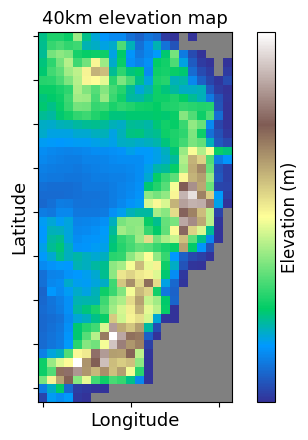

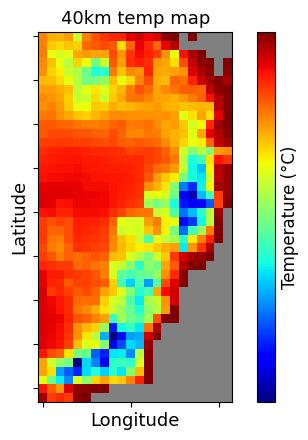

In [ ]:
# Pick one dataset to visualize (will visualize unperturbed test data)
folder = 'data' # replace with your data folder path
resolution = '40km'
truth_file = folder + f'/{resolution}_test.csv'
truth_data = pd.read_csv(truth_file)
true_alt, true_temp = get_alt_temp_grids(truth_data, ocean=False)

# Plotting using functions from alt_extract_helpers.py
plot_area(true_alt, 'elevation', title=f'{resolution} elevation map', grey_back=True)
plot_area(true_temp, 'temperature', title=f'{resolution} temp map', grey_back=True, color='jet')

Using the true elevation data to generate gradients (BFS of nearest peak):

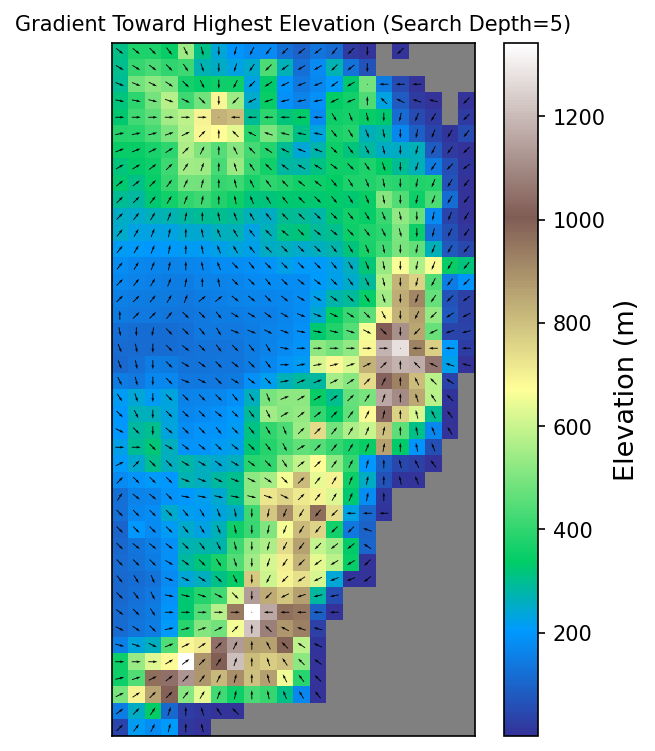

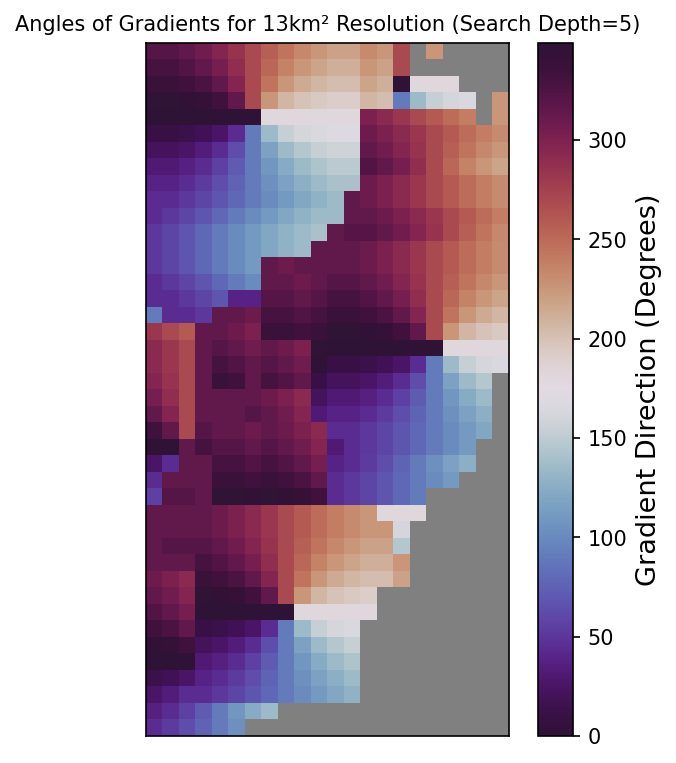

In [10]:
search_depth = 5 # search depth (number of pixels)
nan_val = -100 # deprecated, any arbitrary value works

U, V = gen_elevation_grads(true_alt, search_depth, nan_val=nan_val, grey_back=True)
angles = grad_angles(U, V, title=f'Angles of Gradients for {resolution}² Resolution (Search Depth={search_depth})', grey_back=True)

### Preprocessing and Training

In [ ]:
# Pick one dataset to preprocess and train on
folder = 'data' # replace with your data folder path
resolution = '40km'
n_clusters = 10 # number of clusters to run CFL algorithm with
train_file = folder + f'/{resolution}_data.csv'

train_data = pd.read_csv(train_file)
Xraw = np.array(train_data[['lat', 'long']])
Yraw = np.array(train_data['generated_temp']).reshape(-1,1)

# Standardize data
X = StandardScaler().fit_transform(Xraw)
Y = StandardScaler().fit_transform(Yraw)

In [12]:
# Create 3 dictionaries: one for data info, one with CDE parameters, and one with cluster parameters

# the parameters should be passed in dictionary form
data_info = {'X_dims' : X.shape,
             'Y_dims' : Y.shape,
             'Y_type' : 'continuous' #options: 'categorical' or 'continuous'
            }

# pass in empty parameter dictionaries to use the default parameter values (not
# allowed for data_info)
CDE_params = {  'model'        : 'CondExpMod',
                'model_params' : {
                    # model architecture
                    'dense_units' : [50, data_info['Y_dims'][1]],
                    'activations' : ['relu', 'linear'],
                    'dropouts'    : [0, 0],
                    # training parameters
                    'batch_size'  : 128,
                    'n_epochs'    : 2500,
                    'optimizer'   : 'adam',
                    'opt_config'  : {'lr' : 2e-4},
                    'loss'        : 'mean_squared_error',
                    'best'        : True,
                    'early_stopping' : True,
                    # verbosity
                    'verbose'     : 1,
                    'show_plot'   : True,
                }
}

# cluster_params consists of specifying two clustering objects
# CFL automatically recognizes the names of all sklearn.cluster models as keywords
cause_cluster_params =  {'model' : 'KMeans',
                         'model_params' : {'n_clusters' : n_clusters},
                         'verbose' : 0
}

In [13]:
# block_names indicates which CDE and clustering models to use
block_names = ['CondDensityEstimator', 'CauseClusterer']

# block_params is aligned to block_names
block_params = [CDE_params, cause_cluster_params]

results_path = 'altitude_extraction' # directory to save results to

# Create a CFL experiment with specified parameters
my_exp = Experiment(X_train=X,
                    Y_train=Y,
                    data_info=data_info,
                    block_names=block_names,
                    block_params=block_params,
                    results_path=results_path)

save_path 'altitude_extraction' doesn't exist, creating now.
All results from this run will be saved to altitude_extraction/experiment0000
Block: verbose not specified in input, defaulting to 1
CondExpBase: activity_regularizers not specified in input, defaulting to None
CondExpBase: kernel_regularizers not specified in input, defaulting to None
CondExpBase: bias_regularizers not specified in input, defaulting to None
CondExpBase: kernel_initializers not specified in input, defaulting to None
CondExpBase: bias_initializers not specified in input, defaulting to None
CondExpBase: weights_path not specified in input, defaulting to None
CondExpBase: tb_path not specified in input, defaulting to None
CondExpBase: optuna_callback not specified in input, defaulting to None
CondExpBase: optuna_trial not specified in input, defaulting to None
CondExpBase: checkpoint_name not specified in input, defaulting to tmp_checkpoints


#################### Beginning CFL Experiment training. ####################
Beginning CondDensityEstimator training...
No GPU device detected.
Epoch 1/2500
5/5 [==============================] - 1s 47ms/step - loss: 1.2755 - val_loss: 1.1514
Epoch 2/2500
5/5 [==============================] - 0s 11ms/step - loss: 1.2611 - val_loss: 1.1383
Epoch 3/2500
5/5 [==============================] - 0s 15ms/step - loss: 1.2466 - val_loss: 1.1261
Epoch 4/2500
5/5 [==============================] - 0s 20ms/step - loss: 1.2337 - val_loss: 1.1143
Epoch 5/2500
5/5 [==============================] - 0s 18ms/step - loss: 1.2211 - val_loss: 1.1032
Epoch 6/2500
5/5 [==============================] - 0s 19ms/step - loss: 1.2091 - val_loss: 1.0927
Epoch 7/2500
5/5 [==============================] - 0s 13ms/step - loss: 1.1975 - val_loss: 1.0828
Epoch 8/2500
5/5 [==============================] - 0s 13ms/step - loss: 1.1864 - val_loss: 1.0738
Epoch 9/2500
5/5 [==============================] - 0s 13ms/step

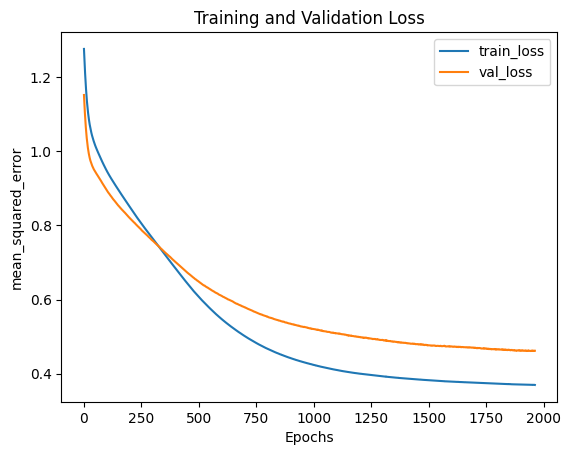

27/27 [==============================] - 0s 777us/step
Loading parameters from  tmp_checkpoints02052025001446/best_weights
Saving parameters to  altitude_extraction/experiment0000/trained_blocks/CondDensityEstimator
CondDensityEstimator training complete.
Beginning CauseClusterer training...
CauseClusterer training complete.
Experiment training complete.


In [14]:
# Run training (will take a bit of time for larger datasets)
results = my_exp.train()

### Visualizing Results

In [15]:
xlbls = results['CauseClusterer']['x_lbls']
print(f'Number of unique xlbls (should match n_clusters): {len(set(xlbls))}')

Number of unique xlbls (should match n_clusters): 10


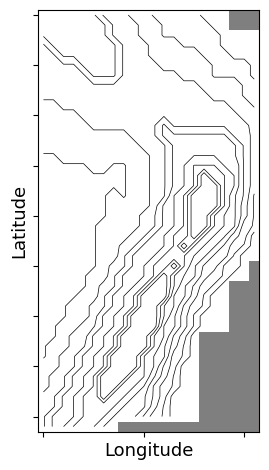

In [16]:
# Plot the clusters as a contour map
_ = reconstruct_contour(train_data, xlbls, n_clusters, title=None, grey_back=True)

### Finding Optimal Cluster Number with a Test Set

Note that a prime test set resolution (in km) makes most sense to ensure no overlap with the training set.

In [ ]:
folder = 'data' # replace with your data folder path
train_resolution = '40km' # replace with desired train set resolution + 'km'
test_resolution = '13km' # replace with desired test set resolution + 'km'
train_file = folder + f'/{train_resolution}_data.csv'
test_file = folder + f'/{test_resolution}_test.csv'

train_data = pd.read_csv(train_file)
trainX, trainY = np.array(train_data[['lat', 'long']]), np.array(train_data['generated_temp']).reshape(-1,1)
trainX = StandardScaler().fit_transform(trainX)
trainY = StandardScaler().fit_transform(trainY)

test_data = pd.read_csv(test_file)
del test_data['elevation']
testX, testY = np.array(test_data[['lat', 'long']]), np.array(test_data['generated_temp']).reshape(-1,1)
testX = StandardScaler().fit_transform(testX)
testY = StandardScaler().fit_transform(testY)

print('Training data shape:', trainX.shape, trainY.shape)
print('Test data shape:', testX.shape, testY.shape)

Training data shape: (833, 2) (833, 1)
Test data shape: (7487, 2) (7487, 1)


In [6]:
# Create 2 dictionaries: one for data info, one with CDE parameters, cluster parameters are to be tested

data_info = {'X_dims' : trainX.shape,
             'Y_dims' : trainY.shape,
             'Y_type' : 'continuous' #options: 'categorical' or 'continuous'
            }

CDE_params = {  'model'        : 'CondExpMod',
                'model_params' : {
                    # model architecture
                    'dense_units' : [50, data_info['Y_dims'][1]],
                    'activations' : ['relu', 'linear'],
                    'dropouts'    : [0, 0],
                    # training parameters
                    # smaller batch size since datasets may be smaller when testing
                    'batch_size'  : 64,
                    'n_epochs'    : 2500,
                    'optimizer'   : 'adam',
                    # smaller learning rate to compensate for smaller batch size
                    'opt_config'  : {'lr' : 1e-4},
                    'loss'        : 'mean_squared_error',
                    'best'        : True,
                    'early_stopping' : True,
                    # verbosity
                    'verbose'     : 0, # don't log or show plot for checking clusters vs accuracy
                    'show_plot'   : False,
                }
}

In [7]:
n_clusters = [1, 2, 3, 5, 7, 10, 15, 20, 30, 40, 50] # number of clusters to run CFL algorithm with
train_errs = []
test_errs = []

# for each number of clusters, run the experiment, predict on the test set, and calculate error
# this will take a while, especially for larger datasets
for n in n_clusters:
    cause_cluster_params =  {'model' : 'KMeans',
                         'model_params' : {'n_clusters' : n},
                         'verbose' : 0
    }

    block_names = ['CondDensityEstimator', 'CauseClusterer']
    block_params = [CDE_params, cause_cluster_params]
    results_path = 'optimal_clusters_testing' # directory to save results to

    my_exp = Experiment(X_train=trainX,
                        Y_train=trainY,
                        data_info=data_info,
                        block_names=block_names,
                        block_params=block_params,
                        results_path=results_path)
    results = my_exp.train()
    xlbls = results['CauseClusterer']['x_lbls']
    train_errs.append(by_point_err(train_data, xlbls, train_data, xlbls))

    my_exp.add_dataset(X=testX, Y=testY, dataset_name='test_data')
    pred_results = my_exp.predict('test_data')
    pred_xlbls = pred_results['CauseClusterer']['x_lbls']
    test_errs.append(by_point_err(train_data, xlbls, test_data, pred_xlbls))

    print(f'train err for {n} clusters: {train_errs[-1]}')
    print(f'test err for {n} clusters: {test_errs[-1]}')

save_path 'optimal_clusters_testing' doesn't exist, creating now.
All results from this run will be saved to optimal_clusters_testing/experiment0000
Block: verbose not specified in input, defaulting to 1
#################### Beginning CFL Experiment training. ####################
Beginning CondDensityEstimator training...
27/27 [==============================] - 0s 917us/step
CondDensityEstimator training complete.
Beginning CauseClusterer training...
CauseClusterer training complete.
Experiment training complete.
Beginning Experiment prediction.
Beginning CondDensityEstimator prediction...
234/234 [==============================] - 0s 889us/step
CondDensityEstimator prediction complete.
Beginning CauseClusterer prediction...
CauseClusterer prediction complete.
Prediction complete.
train err for 1 clusters: 3.0047974340650727
test err for 1 clusters: 3.1590867017864355
All results from this run will be saved to optimal_clusters_testing/experiment0001
#################### Beginning CFL 

In [ ]:
# Visualize n_clusters vs train/test errors
plt.figure(0)
plt.plot(n_clusters, train_errs, label='Train')
plt.plot(n_clusters, test_errs, label='Test')
plt.xlabel('Number of clusters')
plt.ylabel('Mean squared error by cluster')
plt.legend()
_ = plt.title(f'Mean squared error by cluster vs number of clusters - {train_resolution} training set')

NOTE: This section on finding optimal cluster number with a test set can be ran with multiple training sets. The test errors can then be saved and plotted to visualize the shift in optimal cluster number as resolution changes. 